# Training Model/s to predict Sentiment 

In this notebook, we will train model/s using the cleaned movie review dataset (refer to **cleaning** notebook for pre processing steps) to predict the sentiment and evaluate the performance of each

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input, GlobalAveragePooling1D, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from nltk.tokenize import word_tokenize 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
quarter1 = pd.read_csv('../data/clean/cleaned_imdb_data_quarter1.csv')
quarter2 = pd.read_csv('../data/clean/cleaned_imdb_data_quarter2.csv')
quarter3 = pd.read_csv('../data/clean/cleaned_imdb_data_quarter3.csv')
quarter4 = pd.read_csv('../data/clean/cleaned_imdb_data_quarter4.csv')

imdb_data = pd.concat([quarter1, quarter2, quarter3, quarter4], ignore_index=True)

In [11]:
imdb_data

,review,sentiment,padded_sequences
0,one reviewer mentioned watching 1 oz episode y...,positive,[ 4 1023 946 68 417 3107 178 3...
1,wonderful little production filming technique ...,positive,[ 293 47 241 1236 1611 15988 1 13...
2,thought wonderful way spend tear eye hot summe...,positive,[ 97 293 26 994 12 8 788 13...
3,basically there family little boy jake think t...,negative,[ 584 134 125 47 207 3362 31 1...
4,petter matteis love tear eye money visually st...,positive,[ 1 1 36 12 8 200 1977 12...
...,...,...,...
49995,thought movie right good job wasnt creative or...,positive,[ 97 2 107 6 182 192 1348 120 25 ...
49996,bad plot bad dialogue bad acting idiotic direc...,negative,[ 22 41 22 286 22 45 2748 8...
49997,catholic taught parochial elementary school nu...,negative,[ 2958 3919 1 7505 266 4122 3919 ...
49998,im going disagree previous comment side maltin...,negative,[ 66 79 2760 777 345 352 10353 ...


In [3]:
def fix_sequence_format(sequence_str):
    # Remove extra spaces and convert to proper list format
    sequence_str = re.sub(r'\s+', ',', sequence_str.strip())  
    sequence_str = sequence_str.replace('[,', '[')  
    sequence_str = sequence_str.replace(',]', ']')  
    return eval(sequence_str) 

imdb_data['padded_sequences'] = imdb_data['padded_sequences'].apply(fix_sequence_format)

In [4]:
imdb_data.head()

,review,sentiment,padded_sequences
0,one reviewer mentioned watching 1 oz episode y...,positive,"[4, 1023, 946, 68, 417, 3107, 178, 369, 2916, ..."
1,wonderful little production filming technique ...,positive,"[293, 47, 241, 1236, 1611, 15988, 1, 1357, 61,..."
2,thought wonderful way spend tear eye hot summe...,positive,"[97, 293, 26, 994, 12, 8, 788, 1304, 2215, 107..."
3,basically there family little boy jake think t...,negative,"[584, 134, 125, 47, 207, 3362, 31, 134, 525, 3..."
4,petter matteis love tear eye money visually st...,positive,"[1, 1, 36, 12, 8, 200, 1977, 1252, 3, 35, 284,..."


In [5]:
# Convert labels to numerical values (0 for negative, 1 for positive)
imdb_data['sentiment'] = imdb_data['sentiment'].map({'negative': 0, 'positive': 1})
X = imdb_data['padded_sequences'].tolist()
y = imdb_data['sentiment']

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

#split train_val into 70% train and 15% validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.176, random_state=42, stratify=y_train_val
)  # 0.176 ensures 15% of the original dataset goes to validation


In [6]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)

In [7]:
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype, X_val.dtype, y_val.dtype)

int32 int32 int64 int64 int32 int64


In [8]:
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
y_val = y_val.astype(np.int32)

In [9]:
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype, X_val.dtype, y_val.dtype)

int32 int32 int32 int32 int32 int32


In [23]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(35020, 300) (35020,) (7500, 300) (7500,) (7480, 300) (7480,)


In [28]:
model = Sequential([
    Embedding(input_dim=20000, output_dim=128), 
    LSTM(128, return_sequences=True),
    Dropout(0.1),
    LSTM(64), 
    Dense(1, activation='sigmoid')  
])

early_stopping = EarlyStopping(
    monitor="val_loss",  
    patience=3,           
    restore_best_weights=True
)

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [29]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 234s 422ms/step - accuracy: 0.5021 - loss: 0.6936 - val_accuracy: 0.5103 - val_loss: 0.6930
Epoch 2/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 301s 550ms/step - accuracy: 0.5122 - loss: 0.6900 - val_accuracy: 0.5099 - val_loss: 0.6918
Epoch 3/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 291s 531ms/step - accuracy: 0.5140 - loss: 0.6837 - val_accuracy: 0.5053 - val_loss: 0.6942
Epoch 4/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 294s 537ms/step - accuracy: 0.5316 - loss: 0.6583 - val_accuracy: 0.6684 - val_loss: 0.6546
Epoch 5/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 296s 539ms/step - accuracy: 0.6829 - loss: 0.6034 - val_accuracy: 0.7428 - val_loss: 0.5812
Epoch 6/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 299s 546ms/step - accuracy: 0.7680 - loss: 0.5064 - val_accuracy: 0.8000 - val_loss: 0.4442
Epoch 7/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 318s 580ms/step - accuracy: 0.8775 - loss: 0.3078 - val_accuracy: 0.8527 - val_loss: 0.3663
Epoch 8/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 313s 572ms/step - accuracy: 0.9194 -

In [30]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 111ms/step - accuracy: 0.8702 - loss: 0.3341
Test Accuracy: 0.8691


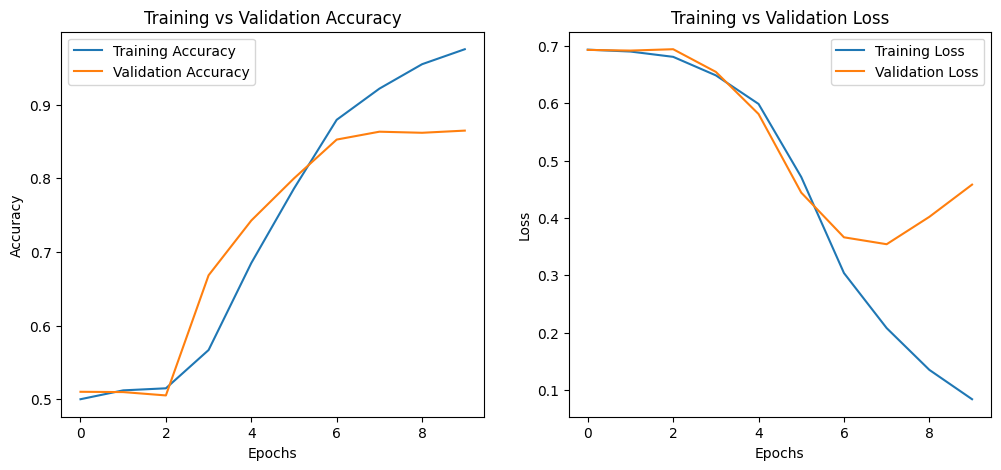

In [31]:
# Extract accuracy and loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create subplots
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Show plots
plt.show()

***

# Transformer

In [11]:
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")  
tokenizer.fit_on_texts(imdb_data['review']) 

In [12]:
# Load GloVe embeddings
def load_glove_embeddings(glove_file, vocab_size, tokenizer, embedding_dim=300):
    embeddings_index = {}

    # Read the GloVe file
    with open(glove_file, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector

    # Create an embedding matrix
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, index in tokenizer.word_index.items():
        if index < vocab_size:  
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector  

    return embedding_matrix

# Load the embeddings
embedding_matrix = load_glove_embeddings("../glove.6B/glove.6B.300d.txt", vocab_size=20000, tokenizer=tokenizer)

In [13]:
# Define Transformer Block
def transformer_block(embed_dim, num_heads, ff_dim, dropout_rate=0.1):
    inputs = Input(shape=(None, embed_dim))
    
    # Multi-Head Self-Attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)  
    
    # Feed Forward Network
    ffn = Dense(ff_dim, activation="relu")(out1)
    ffn = Dense(embed_dim)(ffn)
    ffn = Dropout(dropout_rate)(ffn)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn)     
    
    return Model(inputs=inputs, outputs=out2)

In [16]:
# Define Transformer Model with Pretrained GloVe Embeddings
def create_transformer_model(vocab_size=20000, embed_dim=300, num_heads=4, ff_dim=256, num_transformer_blocks=2, sequence_length=300):
    inputs = Input(shape=(sequence_length,))
    
    # Use GloVe embeddings instead of random embeddings
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim, weights=[embedding_matrix], trainable=False)(inputs)

    # Stack Transformer Blocks
    x = embedding_layer
    for _ in range(num_transformer_blocks):
        x = transformer_block(embed_dim, num_heads, ff_dim)(x)

    # Global Pooling & Dense Layers
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1, activation="sigmoid")(x) 

    # Build Model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Create Model with GloVe embeddings
model = create_transformer_model()

In [17]:
# Define Early Stopping
early_stopping = EarlyStopping(
    monitor="val_loss",   # Stop when validation loss stops improving
    patience=3,           # Wait 3 epochs before stopping
    restore_best_weights=True  # Restore the best model (not the last one)
)

# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Train the Model with Early Stopping
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  
)

Epoch 1/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 1344s 2s/step - accuracy: 0.7268 - loss: 0.5411 - val_accuracy: 0.8511 - val_loss: 0.3470
Epoch 2/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 1332s 2s/step - accuracy: 0.8545 - loss: 0.3400 - val_accuracy: 0.8561 - val_loss: 0.3261
Epoch 3/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 1325s 2s/step - accuracy: 0.8652 - loss: 0.3188 - val_accuracy: 0.8619 - val_loss: 0.3233
Epoch 4/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 1317s 2s/step - accuracy: 0.8709 - loss: 0.3142 - val_accuracy: 0.8640 - val_loss: 0.3233
Epoch 5/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 1327s 2s/step - accuracy: 0.8710 - loss: 0.3017 - val_accuracy: 0.8547 - val_loss: 0.3246
Epoch 6/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 1333s 2s/step - accuracy: 0.8799 - loss: 0.2940 - val_accuracy: 0.8644 - val_loss: 0.3227
Epoch 7/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 1300s 2s/step - accuracy: 0.8811 - loss: 0.2789 - val_accuracy: 0.8668 - val_loss: 0.3151
Epoch 8/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 1358s 2s/step - accuracy: 0.8879 - loss: 0.2674 - 

In [21]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 300, 300)       │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_6 (Functional)       │ (None, 300, 300)       │     1,599,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_7 (Functional)       │ (None, 300, 300)       │     1,599,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 300)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,653,525 (59.71 MB)

 Trainable params: 3,217,841 (12.28 MB)

 Non-trainable params: 6,000,000 (22.89 MB)

 Optimizer params: 6,435,684 (24.55 MB)

In [ ]:
model.save("./baseline_models/transformer_sentiment_model.h5")

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 89s 380ms/step - accuracy: 0.8674 - loss: 0.3010
Test Accuracy: 0.8719


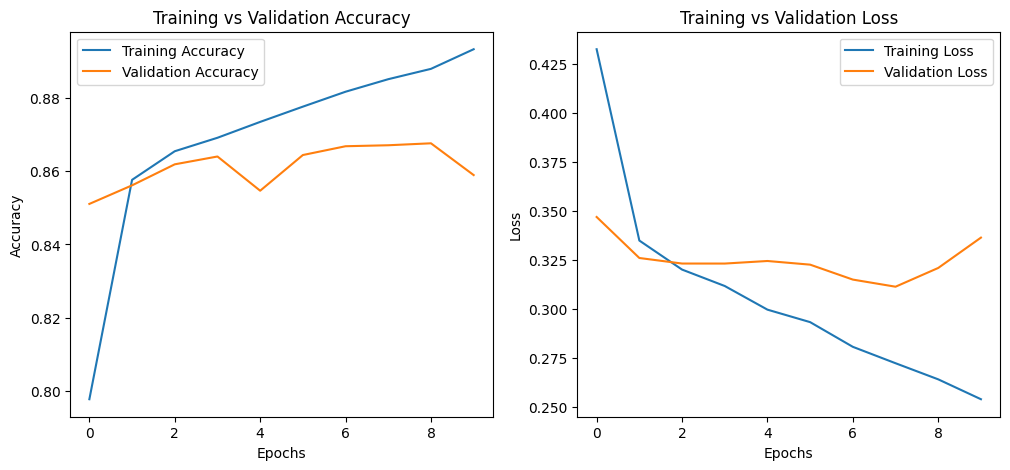

In [19]:
# Extract accuracy and loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create subplots
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Show plots
plt.show()

***